#Overview


* This notebook was created in colab and meant to interface with our team's GCP Bucket (mounts). Link to colab notebook [here](https://drive.google.com/file/d/1GmVixIsCiJLqACfepLAC9mO-gr-Q9-m_/view?usp=sharing).
* Milestone versions of this notebook are in [github](https://github.com/dyeramosu/ac215_snapnutrition)
* This notebook has 2 sections 1) data exploration and 2) model building
* This beginning notebook also helped us to figure out what data we need and what needs to be pre-processed.


# Nutrition5k Dataset EDA



## Nutrition5K Paper DataSource Overview

*   Nurtiion5k paper had their data in a GCP bucket. They have a Google Bucket link [here](https://console.cloud.google.com/storage/browser/nutrition5k_dataset;tab=objects?prefix=&forceOnObjectsSortingFiltering=false)
*   Bucket size total of 181 GB (includes photos and 360-degree surround food videos)
*   Nutrition5k is a medium dataset (less than 2TB). It will not fit in RAM but maybe in local disk
*   Nutrition5k papers did not attempt to identify the food in the images unlike FOODD. Instead it tried to use images at various angles and later depth images.


1) First we'll need to extract the unique ID for each dish image. We will also need the corresponding nutrition info of each food image. The following csv's contain all nutrition metadata at the dish_id-level, as well as per-ingredient mass and macronutrients. The default directory structure is:

```
  └── nutrition5k_dataset
        └──metadata
           ├── dish_metadata_cafe1.csv
           └── dish_metadata_cafe2.csv
```
For each dish ID dish_[10 digit timestamp], there is a CSV entry containing the following fields:

```
dish_id, total_calories, total_mass, total_fat, total_carb, total_protein, num_ingrs,
(ingr_1_id, ingr_1_name, ingr_1_grams, ingr_1_calories, ingr_1_fat, ingr_1_carb, ingr_1_protein, ...)
with the last 8 fields are repeated for every ingredient present in the dish.
```
Note: There is a seperate CSV for each ingredient ID and their nutrition info at:

```
nutrition5k_dataset/nutrition5k_dataset/metadata/ingredients_metadata.csv
```

2) Second we'll need to extract the overhead shot of each image using dish_id. We will ognore the depth shots for each dish_id for now. The default directory structure we will look into is:

```
  └── nutrition5k_dataset
        └──imagery
            └── realsense_overhead
                 ├──dish_{ID}
                 │   ├── depth_color.png
                 │   ├── depth_raw.png
                 │   └── rbg.png
                 ├──dish_{ID}...
                 ...                  
```



## Mount Team SnapNutrition GCP Bucket To Colab

Instead of reading files directly from Nutrion5k's GCP bucket, we transferred a subset of the files of interest (excluding video files) into our own bucket for versioning.

From now on we will use our GCP bucket data source [direct link](https://console.cloud.google.com/storage/browser/snapnutrition_data_bucket?authuser=0&project=csci-115-398800&pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&prefix=&forceOnObjectsSortingFiltering=false)

In [ ]:
#cell to connect to our GCP Bucket
from google.colab import auth

auth.authenticate_user()

#THIS WILL CREATE A GOOGLE POP-UP WINDOW TO LOGIN
#If you do not have access to our bucket, please message brent ruttle

In [ ]:
!gcloud config set project csci-115-398800

Updated property [core/project].


Install package needed to mount GCP Bucket to colab

In [ ]:
!echo "deb https://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  2659  100  2659    0     0  26616      0 --:--:-- --:--:-- --:--:-- 26858
OK
19 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://packages.cloud.google.com/apt/dists/gcsfuse-bionic/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
gcsfuse is already the newest version (1.2.0).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


Make a directory and mount GCP bucket "snapnutrition_data_bucket" to the folder

In [ ]:
!mkdir snapnutrition_data_bucket
!gcsfuse --implicit-dirs snapnutrition_data_bucket snapnutrition_data_bucket
!gcsfuse --implicit-dirs snapnutrition_data_bucket/data/tf_records snapnutrition_data_bucket/data/tf_records

#!chmod 777 -R snap_nutrition_data

mkdir: cannot create directory ‘snapnutrition_data_bucket’: File exists
{"time":"21/10/2023 09:47:52.686113","severity":"INFO","msg":"Start gcsfuse/1.2.0 (Go version go1.21.0) for app \"\" using mount point: /content/snapnutrition_data_bucket\n"}
{"time":"21/10/2023 09:47:53.489008","severity":"INFO","msg":"Start gcsfuse/1.2.0 (Go version go1.21.0) for app \"\" using mount point: /content/snapnutrition_data_bucket/data/tf_records\n"}
daemonize.Run: readFromProcess: sub-process: mountWithArgs: mountWithStorageHandle: fs.NewServer: create file system: SetUpBucket: Error in iterating through objects: storage: bucket doesn't exist


In [ ]:
pip install -q tensorflow-model-optimization

##Exploratory Data Analysis (EDA)

In [ ]:
import pandas as pd
from PIL import Image
import requests
from io import BytesIO
import os
import matplotlib.pyplot as plt
import numpy as np
import shutil
import time
import subprocess
from glob import glob


# sklearn
from sklearn.model_selection import train_test_split

import requests
import tempfile
import zipfile
import tarfile
import shutil
import math
import json
import time
import sys
import cv2
import string
import re
import subprocess
import hashlib
import numpy as np
import pandas as pd
import random
from glob import glob
import collections
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params

# TF Hub
import tensorflow_hub as hub

# TF Optimization
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity.keras import prune_low_magnitude



AUTOTUNE = tf.data.AUTOTUNE
#constants for using the Nutrition5k Research Paper's Public Google Bucket
GOOGLE_BUCKET_DOMAIN = "https://storage.googleapis.com/"
DISH_IMAGES_DIRECTORY = "nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/"
#TFRECORDS_DIRECTORY = "snapnutrition_data_bucket/data/tf_records/180_by_180"
#TFRECORDS_DIRECTORY = "snapnutrition_data_bucket/data/tf_records/180_by_180_dask_normalized"
TFRECORDS_DIRECTORY = "snapnutrition_data_bucket/data/tf_records/224_by_224_dask_normalized"

In [ ]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately,
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
#print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Set the global random seed
tf.random.set_seed(215)
np.random.seed(215)
random.seed(215)

tensorflow version 2.13.0
Eager Execution Enabled: True
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!nvidia-smi

Sat Oct 21 21:48:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    49W / 400W |    679MiB / 40960MiB |      7%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# paths to read train test val data (has image filepaths and corresponding labels
TEST_SAVE_PATH = "./snapnutrition_data_bucket/data/processed_labels/test_data.pickle"

# read train, test, validation data from pickle files
test_xy = pd.read_pickle(TEST_SAVE_PATH)

len(test_xy)

489

In [ ]:
actual_calories = []
actual_mass = []
actual_fat = []
actual_carb = []
actual_protein = []
y_test  = []

for i, element in enumerate(test_xy):
  actual_calories.append(float(element[0][0]))
  actual_mass.append(float(element[0][1]))
  actual_fat.append(float(element[0][2]))
  actual_carb.append(float(element[0][3]))
  actual_protein.append(float(element[0][4]))
  y_test.append([float(element[0][0]),float(element[0][1]), float(element[0][2]), float(element[0][3]), float(element[0][4])])

In [ ]:
def compare_model_sizes(model):
  _, model_file = tempfile.mkstemp(".h5")
  tf.keras.models.save_model(model, model_file, include_optimizer=False)
  # Zip the .h5 model file
  _, zip3 = tempfile.mkstemp(".zip")
  with zipfile.ZipFile(zip3, "w", compression=zipfile.ZIP_DEFLATED) as f:
      f.write(model_file)
  model_before_zip = os.path.getsize(model_file) / float(1000)
  model_after_zip = os.path.getsize(zip3) / float(1000)
  print("Model before zip: %.2f Kb"% model_before_zip)
  print("Model after zip: %.2f Kb"% model_after_zip)
  return model_before_zip, model_after_zip

def download_file(packet_url, base_path="", extract=False, headers=None):
  if base_path != "":
    if not os.path.exists(base_path):
      os.mkdir(base_path)
  packet_file = os.path.basename(packet_url)
  with requests.get(packet_url, stream=True, headers=headers) as r:
      r.raise_for_status()
      with open(os.path.join(base_path,packet_file), 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)

  if extract:
    if packet_file.endswith(".zip"):
      with zipfile.ZipFile(os.path.join(base_path,packet_file)) as zfile:
        zfile.extractall(base_path)
    else:
      packet_name = packet_file.split('.')[0]
      with tarfile.open(os.path.join(base_path,packet_file)) as tfile:
        tfile.extractall(base_path)

class JsonEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, decimal.Decimal):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return super(JsonEncoder, self).default(obj)

experiment_name = "models"
def save_model(model,model_train_history,execution_time, learning_rate, epochs,
               optimizer, evaluation_results, before_zip_size, after_zip_size, inference_time,
               avg_calories_off, avg_mass_off, avg_fat_off, avg_carb_off, avg_protein_off, min_calories_off,
               min_mass_off, min_fat_off, min_carb_off, min_protein_off, max_calories_off, max_mass_off,
               max_fat_off, max_carb_off, max_protein_off):
  model_name=model.name

  # Ensure path exists
  if not os.path.exists(experiment_name):
      os.mkdir(experiment_name)
  # Save the enitire model (structure + weights)
  model.save(os.path.join(experiment_name,model_name+".hdf5"))

  # Save only the weights
  model.save_weights(os.path.join(experiment_name,model_name+".h5"))

  # Save the structure only
  model_json = model.to_json()
  with open(os.path.join(experiment_name,model_name+".json"), "w") as json_file:
      json_file.write(model_json)

  model_size = get_model_size(model_name=model.name)

  # Save model history
  with open(os.path.join(experiment_name,model.name+"_train_history.json"), "w") as json_file:
      json_file.write(json.dumps(model_train_history,cls=JsonEncoder))

  trainable_parameters = count_params(model.trainable_weights)
  non_trainable_parameters = count_params(model.non_trainable_weights)

  # Save model metrics
  metrics ={
      "trainable_parameters":trainable_parameters,
      "execution_time":execution_time,
      "loss":evaluation_results[0],
      "root_mean_squared_error":evaluation_results[1],
      "model_size":model_size,
      "learning_rate":learning_rate,
      "batch_size":batch_size,
      "epochs":epochs,
      "optimizer":type(optimizer).__name__,
      "before_zip_size": before_zip_size,
      "after_zip_size": after_zip_size,
      "test_set_inference_time(min)": inference_time,
      "avg_calories_off":avg_calories_off,
      "avg_mass_off": avg_mass_off,
      "avg_fat_off": avg_fat_off,
      "avg_carb_off": avg_carb_off,
      "avg_protein_off": avg_protein_off,
      "min_calories_off": min_calories_off,
      "min_mass_off": min_mass_off,
      "min_fat_off": min_fat_off,
      "min_carb_off": min_carb_off,
      "min_protein_off": min_protein_off,
      "max_calories_off": max_calories_off,
      "max_mass_off": max_mass_off,
      "max_fat_off": max_fat_off,
      "max_carb_off": max_carb_off,
      "max_protein_off": max_protein_off
  }
  with open(os.path.join(experiment_name,model.name+"_model_metrics.json"), "w") as json_file:
      json_file.write(json.dumps(metrics,cls=JsonEncoder))

def get_model_size(model_name="model01"):
  model_size = os.stat(os.path.join(experiment_name,model_name+".hdf5")).st_size
  return model_size

def append_training_history(model_train_history, prev_model_train_history, metrics=["loss","val_loss","root_mean_squared_error","val_root_mean_squared_error"]):
  for metric in metrics:
    for metric_value in prev_model_train_history[metric]:
      model_train_history[metric].append(metric_value)

  return model_train_history


def evaluate_model(model,test_data, model_train_history,execution_time,
                        learning_rate, batch_size, epochs, optimizer,
                        save=True,
                        loss_metrics=["loss","val_loss"],
                        acc_metrics=["root_mean_squared_error","val_root_mean_squared_error"], evaluation_metrics=None):

  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history[loss_metrics[0]])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in loss_metrics:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  axs = fig.add_subplot(1,2,2)
  axs.set_title('Root Mean Squared Error')
  # Plot all metrics
  for metric in acc_metrics:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()

  # Evaluate on test data
  start_time = time.time()
  evaluation_results = model.evaluate(test_data, return_dict=True)
  print(evaluation_results)
  inference_time = (time.time() - start_time)/60.0
  print("Inference execution time (mins)", inference_time)

  if not evaluation_metrics:
    # for distillation, want to pass previous distill results, not recreate them since will be extra col
    evaluation_results = [evaluation_results[loss_metrics[0]], evaluation_results[acc_metrics[0]]]
  else:
    evaluation_results = evaluation_metrics

  if save:
    # Save model

    # loss = keras.losses.MeanSquaredError()
    # #if evaluation_metrics:
    # model = model.compile(optimizer=optimizer,
    #                 loss=loss,
    #                 metrics=[keras.metrics.RootMeanSquaredError()])

    #should only see big differences if pruned and have 0 weights
    before_zip_size, after_zip_size = compare_model_sizes(model)

    #let's just get the y_pred
    full_test_predicted = model.predict(test_data)
    full_test_results = {'actual_calories': actual_calories, 'pred_calories': full_test_predicted[:, 0], 'actual_mass': actual_mass, 'pred_mass':full_test_predicted[:, 1],
                        'actual_fat': actual_fat, 'pred_fat': full_test_predicted[:, 2], 'actual_carb': actual_carb, 'pred_carb': full_test_predicted[:, 3],'actual_protein': actual_protein, 'pred_protein':full_test_predicted[:,4]}
    full_test_results_df = pd.DataFrame(data=full_test_results)
    full_test_results_df['calorie_estimation_difference'] = full_test_results_df.apply(lambda x: abs(x['actual_calories'] - x['pred_calories']), axis=1)
    full_test_results_df['mass_estimation_difference'] = full_test_results_df.apply(lambda x: abs(x['actual_mass'] - x['pred_mass']), axis=1)
    full_test_results_df['fat_estimation_difference'] = full_test_results_df.apply(lambda x: abs(x['actual_fat'] - x['pred_fat']), axis=1)
    full_test_results_df['carb_estimation_difference'] = full_test_results_df.apply(lambda x: abs(x['actual_carb'] - x['pred_carb']), axis=1)
    full_test_results_df['protein_estimation_difference'] = full_test_results_df.apply(lambda x: abs(x['actual_protein'] - x['pred_protein']), axis=1)
    avg_calories_off =  full_test_results_df.loc[:, 'calorie_estimation_difference'].mean()
    avg_mass_off = full_test_results_df.loc[:, 'mass_estimation_difference'].mean()
    avg_fat_off = full_test_results_df.loc[:, 'fat_estimation_difference'].mean()
    avg_carb_off = full_test_results_df.loc[:, 'carb_estimation_difference'].mean()
    avg_protein_off = full_test_results_df.loc[:, 'protein_estimation_difference'].mean()
    min_calories_off =  full_test_results_df.loc[:, 'calorie_estimation_difference'].min()
    min_mass_off = full_test_results_df.loc[:, 'mass_estimation_difference'].min()
    min_fat_off = full_test_results_df.loc[:, 'fat_estimation_difference'].min()
    min_carb_off = full_test_results_df.loc[:, 'carb_estimation_difference'].min()
    min_protein_off = full_test_results_df.loc[:, 'protein_estimation_difference'].min()
    max_calories_off =  full_test_results_df.loc[:, 'calorie_estimation_difference'].max()
    max_mass_off = full_test_results_df.loc[:, 'mass_estimation_difference'].max()
    max_fat_off = full_test_results_df.loc[:, 'fat_estimation_difference'].max()
    max_carb_off = full_test_results_df.loc[:, 'carb_estimation_difference'].max()
    max_protein_off = full_test_results_df.loc[:, 'protein_estimation_difference'].max()

    print("average calories off: ",  avg_calories_off)
    print("average mass off (grams): ",  avg_mass_off)
    print("average fat off (grams): ", avg_fat_off)
    print("average carb off (grams): ", avg_carb_off)
    print("average protein off (grams): ", avg_protein_off)

    save_model(model, model_train_history,execution_time, learning_rate, epochs, optimizer, evaluation_results, before_zip_size, after_zip_size, inference_time, avg_calories_off, avg_mass_off, avg_fat_off, avg_carb_off, avg_protein_off, min_calories_off, min_mass_off, min_fat_off, min_carb_off, min_protein_off,  max_calories_off,  max_mass_off, max_fat_off, max_carb_off, max_protein_off)

  return evaluation_results

### Create TF Records

In [ ]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
NUM_CHANNELS = 3


In [ ]:
# import pandas as pd
# import os
# import time
# import tensorflow as tf
# import shutil

# import numpy as np
# # Dask
# import dask
# import dask.dataframe as dd
# import dask.delayed as delayed
# from dask.diagnostics import ProgressBar
# import cv2

# print("Begin processing....")

# # paths to read train test val data (has image filepaths and corresponding labels
# TRAIN_SAVE_PATH = "./snapnutrition_data_bucket/data/processed_labels/train_data.pickle"
# VAL_SAVE_PATH = "./snapnutrition_data_bucket/data/processed_labels/validation_data.pickle"
# TEST_SAVE_PATH = "./snapnutrition_data_bucket/data/processed_labels/test_data.pickle"

# # Variables for Resizing Images
# IMAGE_HEIGHT = 224
# IMAGE_WIDTH = 224
# NUM_CHANNELS = 3

# # Split data into multiple TFRecord shards between 100MB to 200MB
# NUM_TRAIN_SHARDS = 12
# NUM_TEST_VAL_SHARDS = 4

# # output directory for this tfrecord creation script
# TFRECORD_SAVE_PATH = './snapnutrition_data_bucket/data/tf_records/224_by_224_dask_normalized'
# # Create an output path to store the tfrecords
# if os.path.exists(TFRECORD_SAVE_PATH):
#     shutil.rmtree(TFRECORD_SAVE_PATH)
# tf.io.gfile.makedirs(TFRECORD_SAVE_PATH)

# # read train, test, validation data from pickle files
# train_xy = pd.read_pickle(TRAIN_SAVE_PATH)
# validate_xy = pd.read_pickle(VAL_SAVE_PATH)
# test_xy = pd.read_pickle(TEST_SAVE_PATH)


# @dask.delayed
# def read_resize_image(file_path):
#   # read image
#   image = cv2.imread(file_path)
#   # convert to rgb
#   image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#   # Resize image
#   image = cv2.resize(image, (IMAGE_WIDTH,IMAGE_HEIGHT), interpolation = cv2.INTER_AREA)

#   return image

# def create_tf_example(item, dask_metrics):
#     # Read image
#     image = tf.io.read_file(item[1])
#     image = tf.image.decode_png(image, channels=NUM_CHANNELS, dtype=tf.uint8)
#     image = tf.cast(image, tf.float32)
#     image = tf.image.resize(image, [IMAGE_HEIGHT, IMAGE_WIDTH])

#     # Custom Normalize image with pre-calculated Dask Metrics
#     # image = (image - dask_metrics['mean']) / dask_metrics['stdev']
#     # # Encode
#     # image = tf.cast(image, tf.uint8)
#     # image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
#     # image = tf.cast(image, tf.uint8)

#     # Label
#     label = item[0]

#     # Build feature dict
#     feature_dict = {
#         'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image.numpy().tobytes()])),
#         'label': tf.train.Feature(float_list=tf.train.FloatList(value=label)),
#     }

#     example = tf.train.Example(features=tf.train.Features(feature=feature_dict))
#     return example


# def create_tf_records(data, dask_metrics, num_shards=10, prefix='', folder='data'):
#     #first use dask to calculate mean


#     num_records = len(data)
#     step_size = num_records // num_shards + 1

#     for i in range(0, num_records, step_size):
#         print("Creating shard:", (i // step_size), " from records:", i, "to", (i + step_size))
#         path = '{}/{}_000{}.tfrecords'.format(folder, prefix, i // step_size)
#         print(path)

#         # Write the file
#         with tf.io.TFRecordWriter(path) as writer:
#             # Filter the subset of data to write to tfrecord file
#             for item in data[i:i + step_size]:
#                 tf_example = create_tf_example(item, dask_metrics)
#                 writer.write(tf_example.SerializeToString())

# #Let's get image mean and stdev from train dataset
# full_train_val = train_xy
# lazy_loaded_images = [read_resize_image(path_and_label[1]) for path_and_label in full_train_val]
# image_arrays = [dask.array.from_delayed(img,dtype=np.float32, shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUM_CHANNELS)) for img in lazy_loaded_images]
# all_images_dask = dask.array.stack(image_arrays, axis=0)

# start_time = time.time()
# dask_computed_metrics = {}
# mean, stdev = dask.compute(all_images_dask.mean(axis=(0,1, 2)), all_images_dask.std(axis=(0,1, 2)))
# print("mean:", mean)
# print("stdev:", stdev)
# dask_computed_metrics ["mean"] = mean
# dask_computed_metrics ["stdev"] = stdev
# execution_time = (time.time() - start_time)/60.0
# print("Execution time (mins)",execution_time)

# # Create TF Records for train
# start_time = time.time()
# create_tf_records(train_xy, dask_computed_metrics, num_shards=NUM_TRAIN_SHARDS, prefix="train", folder=TFRECORD_SAVE_PATH)
# execution_time = (time.time() - start_time) / 60.0
# print("Train TFRecords Execution time (mins)", execution_time)

# # Create TF Records for validation
# start_time = time.time()
# create_tf_records(validate_xy, dask_computed_metrics, num_shards=NUM_TEST_VAL_SHARDS, prefix="val", folder=TFRECORD_SAVE_PATH)
# execution_time = (time.time() - start_time) / 60.0
# print("Validation TFRecords Execution time (mins)", execution_time)

# # Create TF Records for test
# start_time = time.time()
# create_tf_records(test_xy, dask_computed_metrics, num_shards=NUM_TEST_VAL_SHARDS, prefix="test", folder=TFRECORD_SAVE_PATH)
# execution_time = (time.time() - start_time) / 60.0
# print("Test TFRecords Execution time (mins)", execution_time)


# Model Building

1. full_label_df connects unique dish_id's to the nutrition info
2. dish_id also corresponds to the image directory to get the regular png (we will exclude depth images for now)

**Model Input:** will be the overhead image png


**Model Output:** will be (total_calories, total_mass, total_fat, total_carb, total_protein)


Followed this tutorial for loading images via tensorflow https://www.tensorflow.org/tutorials/load_data/images

## Load TF Data from TFRecords

In [ ]:
from IPython.testing import test
batch_size = 128

# Read TF Records
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([5], tf.float32, default_value=[0.0, 0.0, 0.0, 0.0, 0.0])
}

# @tf.function
def parse_tfrecord_example(example_proto):
  parsed_example = tf.io.parse_single_example(example_proto, feature_description)

  # Image
  #image = tf.image.decode_jpeg(parsed_example['image'])
  image = tf.io.decode_raw(parsed_example['image'], tf.float32)
  image.set_shape([NUM_CHANNELS * IMAGE_HEIGHT * IMAGE_WIDTH])
  image = tf.reshape(image, [IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS])
  # Label
  label = parsed_example['label']

  return image, label

# # Normalize pixels
# def normalize(image, label):
#   image = image/255
#   return image, label

# Read the tfrecord files
train_tfrecord_files = tf.data.Dataset.list_files(TFRECORDS_DIRECTORY+'/train*')
validate_tfrecord_files = tf.data.Dataset.list_files(TFRECORDS_DIRECTORY+'/val*')
test_tfrecord_files = tf.data.Dataset.list_files(TFRECORDS_DIRECTORY+'/test*')


#############
# Train data
#############
train_data = train_tfrecord_files.flat_map(tf.data.TFRecordDataset)
train_data = train_data.map(parse_tfrecord_example, num_parallel_calls=tf.data.AUTOTUNE)
#train_data = train_data.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.batch(batch_size)
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)

##################
# Validation data
##################
validation_data = validate_tfrecord_files.flat_map(tf.data.TFRecordDataset)
validation_data = validation_data.map(parse_tfrecord_example, num_parallel_calls=tf.data.AUTOTUNE)
#validation_data = validation_data.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.prefetch(buffer_size=tf.data.AUTOTUNE)

##################
# Test data
##################
test_data = test_tfrecord_files.flat_map(tf.data.TFRecordDataset)
test_data = test_data.map(parse_tfrecord_example, num_parallel_calls=tf.data.AUTOTUNE)
#test_data = test_data.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size)
test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE)

print("train_data",train_data)
print("validation_data",validation_data)
print("test_data",test_data)


train_data <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
validation_data <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
test_data <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>


https://colab.research.google.com/drive/18FBb3MiV4IcPPcJmteLZvE727Ec2QAhA?usp=sharing#scrollTo=uHAXY_VwmjAQ

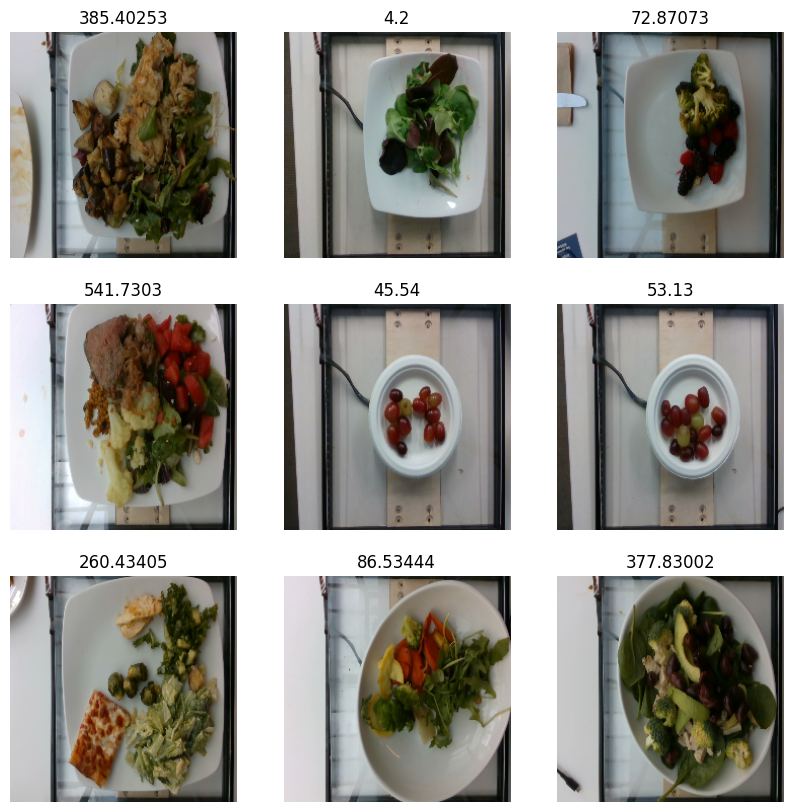

In [ ]:
image_batch, label_batch = next(iter(train_data))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  img = image_batch[i].numpy()
  #img = (img + dask_computed_metrics['mean']) * dask_computed_metrics['stdev']
  img = img.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))
  img = img.astype(np.uint8)

  plt.imshow(img)
  label = label_batch[i]
  plt.title(label.numpy()[0]) #preview calories only
  plt.axis("off")

The above images with total calories at the title look like the data has been set-up correctly. Calories visually seem to make sense too. Note that we have other macro info, but are only displaying the calories for this preview.

**Next standardize the data in case missed in preprocessing pipeline**

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here we standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

### Build Teacher Model

#### **Teacher Model**

Teacher model is a mobilenet_v2 model which we get from directly from tfhub.

In [ ]:
def build_teacher_model(image_height, image_width, num_channels, num_classes):

  # Model input
  input_shape = [image_height, image_width, num_channels] # height, width, channels

  # Handle to pretrained model (Use a different model here)
  handle = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

  # Regularize using L1
  kernel_weight = 0.02
  bias_weight = 0.02

  # model = Sequential([
  #       keras.layers.InputLayer(input_shape=input_shape),
  #                               hub.KerasLayer(handle, trainable=False),
  #       keras.layers.Dense(units=64, activation='relu',
  #                          kernel_regularizer=keras.regularizers.l1(kernel_weight),
  #                          bias_regularizer=keras.regularizers.l1(bias_weight)
  #                          ),
  #       keras.layers.Dense(units=num_macros,
  #                          kernel_regularizer=keras.regularizers.l1(kernel_weight),
  #                          bias_regularizer=keras.regularizers.l1(bias_weight)),
  # ], name='teacher_model')
  model = Sequential([
        keras.layers.InputLayer(input_shape=input_shape),
                                hub.KerasLayer(handle, trainable=False),
        keras.layers.Dense(units=64, activation='relu'),
        keras.layers.Dense(units=num_classes)
  ], name='teacher_model')

  return model

#### **Train Teacher**

Nothing magical about this step. We just train the teacher network.

Model: "teacher_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 2340293 (8.93 MB)
Trainable params: 82309 (321.52 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________
None
Epoch 1/20
18/18 [==============================] - 97s 5s/step - loss: 36607.5391 - root_mean_squared_error: 191.3310 - val_loss: 35537.9648 - val_root_mean_squared_error: 188.5152
Epoch 2/20
18/18 [==============================] - 4s 202ms/step - loss: 36455.0586 - r

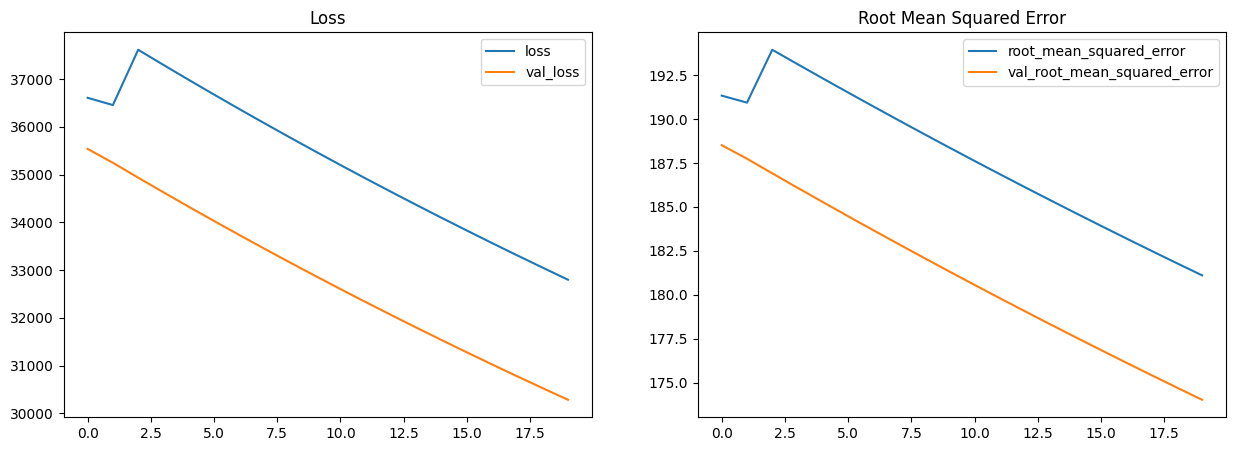

4/4 [==============================] - 0s 45ms/step - loss: 30285.2852 - root_mean_squared_error: 174.0267
{'loss': 30285.28515625, 'root_mean_squared_error': 174.0266571044922}
Inference execution time (mins) 0.004197752475738526


<ipython-input-11-390b7277a91f>:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, model_file, include_optimizer=False)


Model before zip: 9613.73 Kb
Model after zip: 8723.89 Kb
4/4 [==============================] - 1s 55ms/step
average calories off:  216.9827372662129
average mass off (grams):  183.524110844774
average fat off (grams):  11.451784900810516
average carb off (grams):  15.982465738304919
average protein off (grams):  15.815451796800811


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[30285.28515625, 174.0266571044922]

In [ ]:
############################
# Training Params
############################
learning_rate = 0.001
initial_epoch = 0
epochs = 20
num_macros = 5

# Load pre trained model during demos
LOAD_PREV_TRAINED = False

# Free up memory
K.clear_session()

# Optimizer
optimizer = keras.optimizers.RMSProp(learning_rate=learning_rate)
# Loss
#loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss = keras.losses.MeanSquaredError()

# Build or Load Model
if not LOAD_PREV_TRAINED:
  # Build the teacher model
  teacher_model = build_teacher_model(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, num_macros)
  print(teacher_model.summary())

  # Compile
  teacher_model.compile(optimizer=optimizer,
                      loss=loss,
                      metrics=[keras.metrics.RootMeanSquaredError()])
                      #metrics=[keras.metrics.SparseCategoricalAccuracy()])

else:
  # Load model
  teacher_model = keras.models.load_model("distil_models/teacher_model.hdf5", custom_objects={'KerasLayer':hub.KerasLayer})
  print(teacher_model.summary())


  with open("distil_models/teacher_model_train_history.json") as json_file:
    prev_training_history = json.load(json_file)
  with open("distil_models/teacher_model_model_metrics.json") as json_file:
    model_metrics = json.load(json_file)

  epochs = len(prev_training_history["loss"])
  initial_epoch=epochs
  epochs=epochs+3 # Continue training for a few more epochs


# Train model
start_time = time.time()
training_results = teacher_model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        initial_epoch=initial_epoch,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Get model training history
training_history = training_results.history

if LOAD_PREV_TRAINED:
  # Append previous training history & time
  training_history = append_training_history(training_results.history,
                                             prev_training_history,
                                             metrics=["loss","val_loss","root_mean_squared_errorr","val_root_mean_squared_error"])
  execution_time = model_metrics["execution_time"] + execution_time

# Evaluate model
evaluate_model(teacher_model, validation_data, training_history, execution_time,
                    learning_rate, batch_size, epochs, optimizer,
                    save=True,
                    loss_metrics=["loss","val_loss"],
                    acc_metrics=["root_mean_squared_error","val_root_mean_squared_error"])

In [ ]:
full_test_predicted = teacher_model.predict(test_data)
full_test_predicted[:5]

4/4 [==============================] - 21s 4s/step


array([[33.869995 , 28.520426 ,  1.6971029,  2.6033654,  2.3734486],
       [33.869995 , 28.520426 ,  1.6971029,  2.6033654,  2.3734486],
       [33.780807 , 28.604023 ,  1.6167351,  2.7320533,  2.2581139],
       [33.869995 , 28.520426 ,  1.6971029,  2.6033654,  2.3734486],
       [33.869995 , 28.520426 ,  1.6971029,  2.6033654,  2.3734486]],
      dtype=float32)

#### **Student Model**

Student model is just 2 conv layers with max pooling and a dense layer

In [ ]:
def build_student_model(image_height, image_width, num_channels, num_classes, model_name='student'):
  # Model input
  input_shape = [image_height, image_width, num_channels]  # height, width, channels

  model = Sequential(
      [
        keras.Input(shape=input_shape),
        keras.layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(2, 2), padding="same",
                            kernel_initializer=keras.initializers.GlorotUniform(seed=1212)),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),
        keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(2, 2), padding="same",
                            kernel_initializer=keras.initializers.GlorotUniform(seed=2121)),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),
        keras.layers.Flatten(),
        # keras.layers.Dense(units=32, kernel_initializer=keras.initializers.GlorotUniform(seed=2323)),
        keras.layers.Dense(units=num_classes, kernel_initializer=keras.initializers.GlorotUniform(seed=3434))
      ],
      name=model_name)

  return model

#### **Train Student from Scratch**

We do this for for comparison purposes

Model: "student_scratch"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 8)       224       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 112, 112, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 56, 56, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        1168      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                              

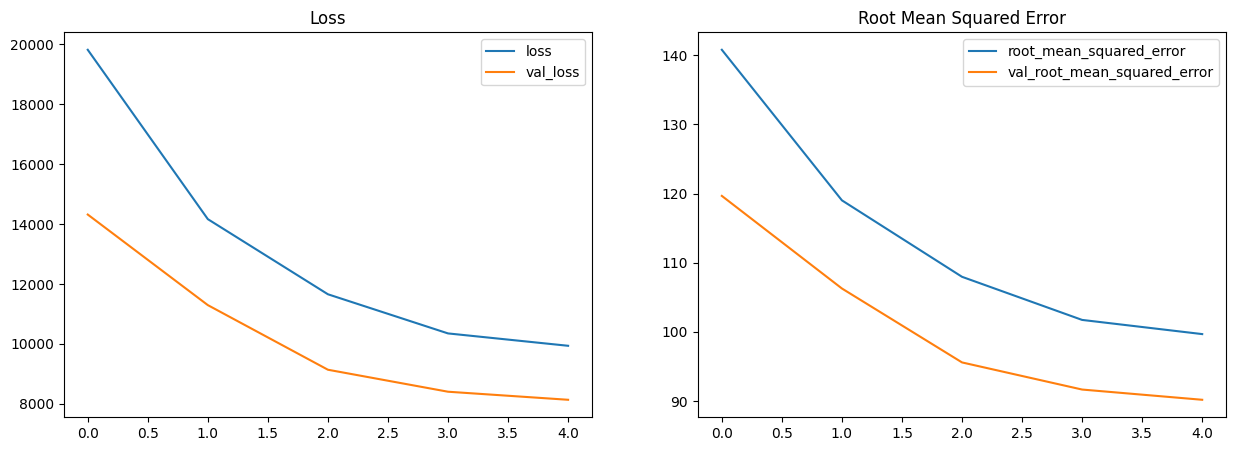

4/4 [==============================] - 0s 48ms/step - loss: 8135.3711 - root_mean_squared_error: 90.1963
{'loss': 8135.37109375, 'root_mean_squared_error': 90.19629669189453}
Inference execution time (mins) 0.003949932257334391
Model before zip: 89.82 Kb
Model after zip: 66.14 Kb
      1/Unknown - 0s 133ms/step

<ipython-input-11-390b7277a91f>:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, model_file, include_optimizer=False)


4/4 [==============================] - 0s 42ms/step
average calories off:  190.86150827437092
average mass off (grams):  147.29825157164797
average fat off (grams):  15.184627466642722
average carb off (grams):  15.844786631716662
average protein off (grams):  19.254875559881633


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[8135.37109375, 90.19629669189453]

In [ ]:
############################
# Training Params
############################
learning_rate = 0.001
epochs = 5

# Free up memory
K.clear_session()

# Build the model
student_model_scratch = build_student_model(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, num_macros, model_name='student_scratch')
print(student_model_scratch.summary())

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
loss = keras.losses.MeanSquaredError()
# Compile
student_model_scratch.compile(optimizer=optimizer,
                      loss=loss,
                      metrics=[keras.metrics.RootMeanSquaredError()])

# Train teacher model
start_time = time.time()
training_results = student_model_scratch.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Get model training history
training_history = training_results.history

# Evaluate model
evaluate_model(student_model_scratch,validation_data, training_history,execution_time,
                    learning_rate, batch_size, epochs, optimizer,
                    save=True,
                    loss_metrics=["loss","val_loss"],
                    acc_metrics=["root_mean_squared_error","val_root_mean_squared_error"])


## **<font color="#324bd9">Build Distiller</font>**

In [ ]:
class Distiller(Model):
    def __init__(self, teacher, student):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(self, optimizer, metrics, student_loss_fn, distillation_loss_fn, Lambda = 0.1, temperature=3):
      """
      optimizer: Keras optimizer for the student weights
      metrics: Keras metrics for evaluation
      student_loss_fn: Loss function of difference between student predictions and ground-truth
      distillation_loss_fn: Loss function of difference between soft student predictions and soft teacher predictions
      lambda: weight to student_loss_fn and 1-alpha to distillation_loss_fn
      temperature: Temperature for softening probability distributions. Larger temperature gives softer distributions.
      """
      super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
      self.student_loss_fn = student_loss_fn
      self.distillation_loss_fn = distillation_loss_fn

      #hyper-parameters
      self.Lambda = Lambda
      self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher (professor)
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.Lambda * student_loss + (1 - self.Lambda) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

## **<font color="#324bd9">Distill Teacher to Student</font>**

Model: "student_distill"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 8)       224       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 112, 112, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 56, 56, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        1168      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                              

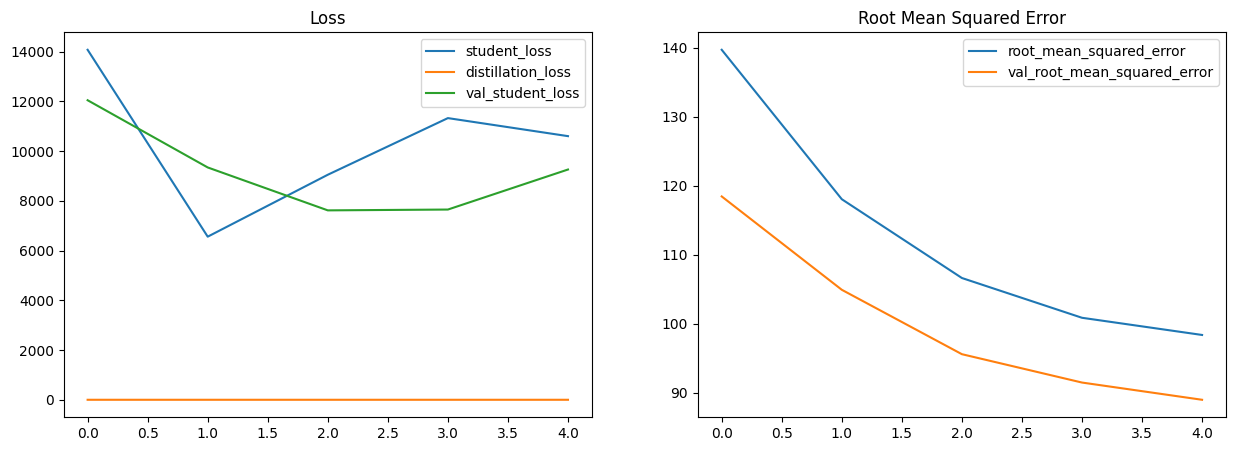

4/4 [==============================] - 0s 46ms/step - root_mean_squared_error: 88.9654 - student_loss: 7756.0845
{'root_mean_squared_error': 88.9654312133789, 'student_loss': 7241.94482421875}
Inference execution time (mins) 0.0038337866465250653


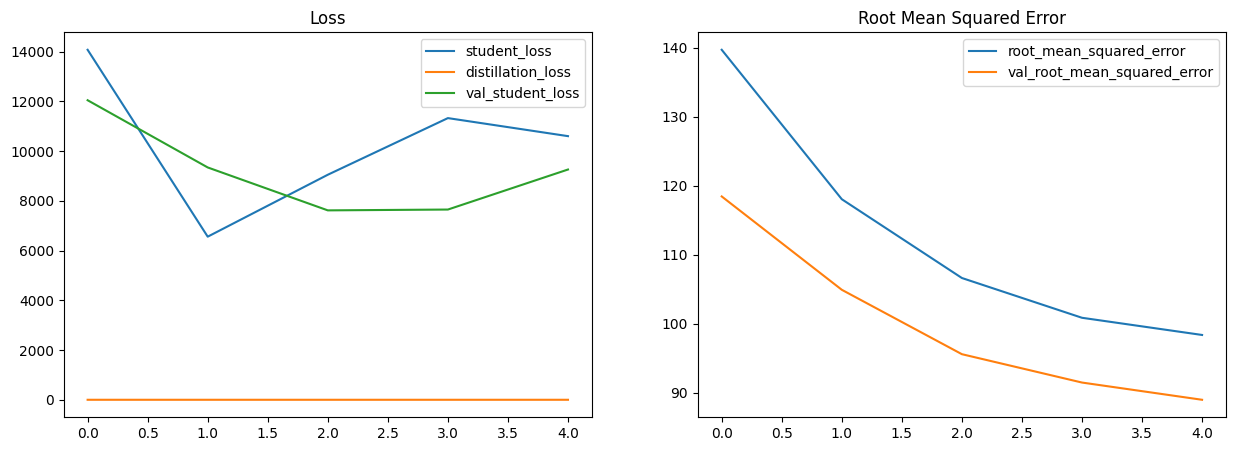

4/4 [==============================] - 0s 53ms/step - loss: 7914.8477 - root_mean_squared_error: 88.9654
{'loss': 7914.84765625, 'root_mean_squared_error': 88.96542358398438}
Inference execution time (mins) 0.005769999821980795
Model before zip: 89.82 Kb
Model after zip: 66.13 Kb
      1/Unknown - 0s 127ms/step

<ipython-input-28-1cf6c3e60f24>:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, model_file, include_optimizer=False)


4/4 [==============================] - 0s 46ms/step
average calories off:  193.9367800495132
average mass off (grams):  149.53439523447267
average fat off (grams):  13.259142518173027
average carb off (grams):  14.941523985718215
average protein off (grams):  18.996401534330076


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[7241.94482421875, 88.9654312133789]

In [ ]:
############################
# Training Params
############################
learning_rate = 0.001
epochs = 5
Lambda = 0.75
temperature= 12

# Free up memory
K.clear_session()

# Build Student model
student_model = build_student_model(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, num_macros, model_name='student_distill')
print(student_model.summary())

# Build the distiller model
distiller_model = Distiller(teacher=teacher_model, student=student_model)

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
student_loss = keras.losses.MeanSquaredError()
#distillation_loss = keras.losses.KLDivergence()
distillation_loss = keras.losses.MeanSquaredError()

# Compile
distiller_model.compile(
    optimizer=optimizer,
    student_loss_fn=student_loss,
    distillation_loss_fn=distillation_loss,
    metrics=[keras.metrics.RootMeanSquaredError()],
    Lambda=Lambda,
    temperature=temperature
)

# Distill teacher to student
start_time = time.time()
training_results = distiller_model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Get model training history
training_history = training_results.history

# Evaluate model
evaluation_results = evaluate_model(distiller_model,validation_data,
               training_history,execution_time,learning_rate, batch_size, epochs, optimizer,
               save=False,
               loss_metrics=["student_loss","distillation_loss","val_student_loss"],
               acc_metrics=["root_mean_squared_error","val_root_mean_squared_error"])

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
loss = keras.losses.MeanSquaredError()
# Compile
student_model_scratch.compile(optimizer=optimizer,
                      loss=loss,
                      metrics=[keras.metrics.RootMeanSquaredError()])
# Compile
student_model.compile( optimizer=optimizer,
                      loss=loss,
                      metrics=[keras.metrics.RootMeanSquaredError()]
)


# Save student model
#save_model(student_model,training_history,execution_time,learning_rate, epochs, optimizer, evaluation_results)
evaluate_model(student_model, validation_data,
               training_history,execution_time,learning_rate, batch_size, epochs, optimizer,
               save=True,
               loss_metrics=["student_loss","distillation_loss","val_student_loss"],
               acc_metrics=["root_mean_squared_error","val_root_mean_squared_error"], evaluation_metrics=evaluation_results)

## **<font color="#324bd9">Compare All Models</font>**

In [ ]:
models_folder = "models" # distil_models / models
models_metrics_list = glob(models_folder+"/*_metrics.json")

all_models_metrics = []
for mm_file in models_metrics_list:
  with open(mm_file) as json_file:
    model_metrics = json.load(json_file)
    model_metrics["name"] = mm_file.replace(models_folder+"/","").replace("_model_metrics.json","")
    all_models_metrics.append(model_metrics)

# Load metrics to dataframe
view_metrics = pd.DataFrame(data=all_models_metrics)

view_metrics.head()

,trainable_parameters,execution_time,loss,root_mean_squared_error,model_size,learning_rate,batch_size,epochs,optimizer,before_zip_size,...,min_mass_off,min_fat_off,min_carb_off,min_protein_off,max_calories_off,max_mass_off,max_fat_off,max_carb_off,max_protein_off,name
0,17077,0.140637,7241.944824,88.965431,95424,0.001,128,5,Adam,89.816,...,0.457260,0.011587,0.108448,0.107918,1129.653336,987.069290,73.574562,90.991766,126.017941,student_distill
1,17077,0.119842,8135.371094,90.196297,246216,0.001,128,5,Adam,89.816,...,0.434273,0.002576,0.027107,0.036485,1126.767166,980.701363,61.192446,85.023203,127.163572,student_scratch
2,82309,1.967088,30285.285156,174.026657,9948824,0.001,128,20,SGD,9613.728,...,0.637960,0.091132,0.008357,0.002551,1230.678345,1073.479574,64.138045,98.652769,141.119044,teacher_model


In [ ]:
# Format columns
view_metrics['root_mean_squared_error'] = view_metrics['root_mean_squared_error']*100
view_metrics['root_mean_squared_error'] = view_metrics['root_mean_squared_error'].map('{:,.2f}%'.format)

view_metrics['trainable_parameters'] = view_metrics['trainable_parameters'].map('{:,.0f}'.format)
view_metrics['execution_time'] = view_metrics['execution_time'].map('{:,.2f} mins'.format)
view_metrics['loss'] = view_metrics['loss'].map('{:,.2f}'.format)
view_metrics['model_size'] = view_metrics['model_size']/1000000
view_metrics['model_size'] = view_metrics['model_size'].map('{:,.3f} MB'.format)

view_metrics = view_metrics.sort_values(by=['root_mean_squared_error'],ascending=False)
view_metrics.head()

,trainable_parameters,execution_time,loss,root_mean_squared_error,model_size,learning_rate,batch_size,epochs,optimizer,before_zip_size,...,min_mass_off,min_fat_off,min_carb_off,min_protein_off,max_calories_off,max_mass_off,max_fat_off,max_carb_off,max_protein_off,name
1,"17,077",0.12 mins,"8,135.37","9,019.63%",0.246 MB,0.001,128,5,Adam,89.816,...,0.434273,0.002576,0.027107,0.036485,1126.767166,980.701363,61.192446,85.023203,127.163572,student_scratch
0,"17,077",0.14 mins,"7,241.94","8,896.54%",0.095 MB,0.001,128,5,Adam,89.816,...,0.457260,0.011587,0.108448,0.107918,1129.653336,987.069290,73.574562,90.991766,126.017941,student_distill
2,"82,309",1.97 mins,"30,285.29","17,402.67%",9.949 MB,0.001,128,20,SGD,9613.728,...,0.637960,0.091132,0.008357,0.002551,1230.678345,1073.479574,64.138045,98.652769,141.119044,teacher_model


## **<font color="#324bd9">Pruning</font>**

We can compress a model by model pruning. Pruning is where we set the weights of a network connection to zero for those which have a very small value. This can help reduce the size of the model

#### **Train Model from Scratch**

Model: "before_prune"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 8)       224       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 112, 112, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 56, 56, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        1168      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                 

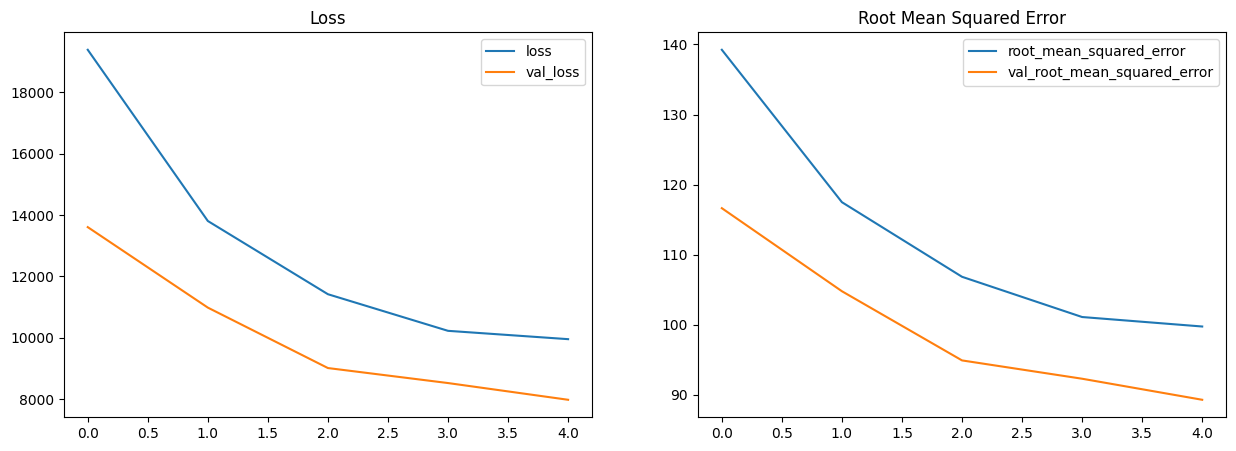

4/4 [==============================] - 0s 45ms/step - loss: 7974.0308 - root_mean_squared_error: 89.2974
{'loss': 7974.03076171875, 'root_mean_squared_error': 89.29742431640625}
Inference execution time (mins) 0.003942251205444336
Model before zip: 89.82 Kb
Model after zip: 66.13 Kb
      1/Unknown - 0s 145ms/step

<ipython-input-28-1cf6c3e60f24>:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, model_file, include_optimizer=False)


4/4 [==============================] - 0s 45ms/step
average calories off:  196.340129219925
average mass off (grams):  151.78293847940208
average fat off (grams):  13.715348857502569
average carb off (grams):  16.66682415851725
average protein off (grams):  18.902109984628446


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[7974.03076171875, 89.29742431640625]

In [ ]:
############################
# Training Params
############################
learning_rate = 0.001
epochs = 5

# Free up memory
K.clear_session()

# Build the model
before_prune = build_student_model(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, num_macros, model_name='before_prune')
print(before_prune.summary())

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
loss = keras.losses.MeanSquaredError()
# Compile
before_prune.compile(optimizer=optimizer,
                      loss=loss,
                      metrics=[keras.metrics.RootMeanSquaredError()])

# Train model
start_time = time.time()
training_results = before_prune.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Get model training history
training_history = training_results.history

# Evaluate model
evaluate_model(before_prune, validation_data, training_history,execution_time,
               learning_rate, batch_size, epochs, optimizer,
               save=True,
               loss_metrics=["loss","val_loss"],
               acc_metrics=["root_mean_squared_error","val_root_mean_squared_error"])

#### **Analyze Model Weights**

Check how many weigths are zero. Usually most weights in a network have a very small values but are not zero.

In [ ]:
def check_model_weights(model):
  for i, w in enumerate(model.get_weights()):
    print(model.weights[i].name,"Total:",w.size, "Zeros:", round(np.sum(np.abs(w) <= 0.0001) / w.size * 100,6),"%")

check_model_weights(before_prune)

conv2d/kernel:0 Total: 216 Zeros: 0.0 %
conv2d/bias:0 Total: 8 Zeros: 0.0 %
conv2d_1/kernel:0 Total: 1152 Zeros: 0.086806 %
conv2d_1/bias:0 Total: 16 Zeros: 0.0 %
dense/kernel:0 Total: 15680 Zeros: 0.223214 %
dense/bias:0 Total: 5 Zeros: 0.0 %


#### **Model Size on Disk**

A simple way to ship models is to `zip` the model file. If we `zip` the model before pruning we see that there is not much difference.

In [ ]:
def compare_model_sizes(model):
  _, model_file = tempfile.mkstemp(".h5")
  tf.keras.models.save_model(model, model_file, include_optimizer=False)
  # Zip the .h5 model file
  _, zip3 = tempfile.mkstemp(".zip")
  with zipfile.ZipFile(zip3, "w", compression=zipfile.ZIP_DEFLATED) as f:
      f.write(model_file)
  model_before_zip = os.path.getsize(model_file) / float(1000)
  model_after_zip = os.path.getsize(zip3) / float(1000)
  print("Model before zip: %.2f Kb"% model_before_zip)
  print("Model after zip: %.2f Kb"% model_after_zip)
  return model_before_zip, model_after_zip


In [ ]:
model_before_zip, model_after_zip = compare_model_sizes(before_prune)

Model before zip: 89.82 Kb
Model after zip: 66.13 Kb


<ipython-input-35-9ea667a9bd7d>:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, model_file, include_optimizer=False)


In [ ]:
#Compare performance
models_folder = "models" # distil_models / models
models_metrics_list = glob(models_folder+"/*_metrics.json")

all_models_metrics = []
for mm_file in models_metrics_list:
  with open(mm_file) as json_file:
    model_metrics = json.load(json_file)
    model_metrics["name"] = mm_file.replace(models_folder+"/","").replace("_model_metrics.json","")
    all_models_metrics.append(model_metrics)

# Load metrics to dataframe
view_metrics = pd.DataFrame(data=all_models_metrics)

view_metrics.head()

,trainable_parameters,execution_time,loss,root_mean_squared_error,model_size,learning_rate,batch_size,epochs,optimizer,before_zip_size,...,min_mass_off,min_fat_off,min_carb_off,min_protein_off,max_calories_off,max_mass_off,max_fat_off,max_carb_off,max_protein_off,name
0,17077,0.140637,7241.944824,88.965431,95424,0.001,128,5,Adam,89.816,...,0.457260,0.011587,0.108448,0.107918,1129.653336,987.069290,73.574562,90.991766,126.017941,student_distill
1,17077,0.119842,8135.371094,90.196297,246216,0.001,128,5,Adam,89.816,...,0.434273,0.002576,0.027107,0.036485,1126.767166,980.701363,61.192446,85.023203,127.163572,student_scratch
2,82309,1.967088,30285.285156,174.026657,9948824,0.001,128,20,SGD,9613.728,...,0.637960,0.091132,0.008357,0.002551,1230.678345,1073.479574,64.138045,98.652769,141.119044,teacher_model
3,17077,0.089208,7974.030762,89.297424,246216,0.001,128,5,Adam,89.816,...,0.156631,0.036588,0.001383,0.037563,1170.783775,848.394669,64.818007,69.245327,133.587146,before_prune


#### **Prune Model**

Now we use the tf optimization library to prune our model

In [ ]:
# paths to read train test val data (has image filepaths and corresponding labels
TRAIN_SAVE_PATH = "./snapnutrition_data_bucket/data/processed_labels/train_data.pickle"

# read train, test, validation data from pickle files
train_xy = pd.read_pickle(TRAIN_SAVE_PATH)

len(train_xy)

2282

In [ ]:
# Define model for pruning
epochs = 5
end_step = np.ceil(len(train_xy) / batch_size).astype(np.int32) * epochs

pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}
model_for_pruning = prune_low_magnitude(before_prune, **pruning_params)
model_for_pruning._name = "after_prune"

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
loss = keras.losses.MeanSquaredError()
# Compile
model_for_pruning.compile(optimizer=optimizer,
                      loss=loss,
                      metrics=[keras.metrics.RootMeanSquaredError()])

model_for_pruning.summary()

# Callback
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep()
]

# Train
start_time = time.time()
training_results = model_for_pruning.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

Model: "after_prune"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 112, 112, 8)       442       
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_leaky_  (None, 112, 112, 8)       1         
 re_lu (PruneLowMagnitude)                                       
                                                                 
 prune_low_magnitude_max_po  (None, 56, 56, 8)         1         
 oling2d (PruneLowMagnitude                                      
 )                                                               
                                                                 
 prune_low_magnitude_conv2d  (None, 28, 28, 16)        2322      
 _1 (PruneLowMagnitude)                                          
                                                       

#### **Analyze Pruned Weights**

In [ ]:
# Get the model back after pruning
after_prune = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
after_prune.summary()

check_model_weights(after_prune)

Model: "after_prune"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 8)       224       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 112, 112, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 56, 56, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        1168      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                  

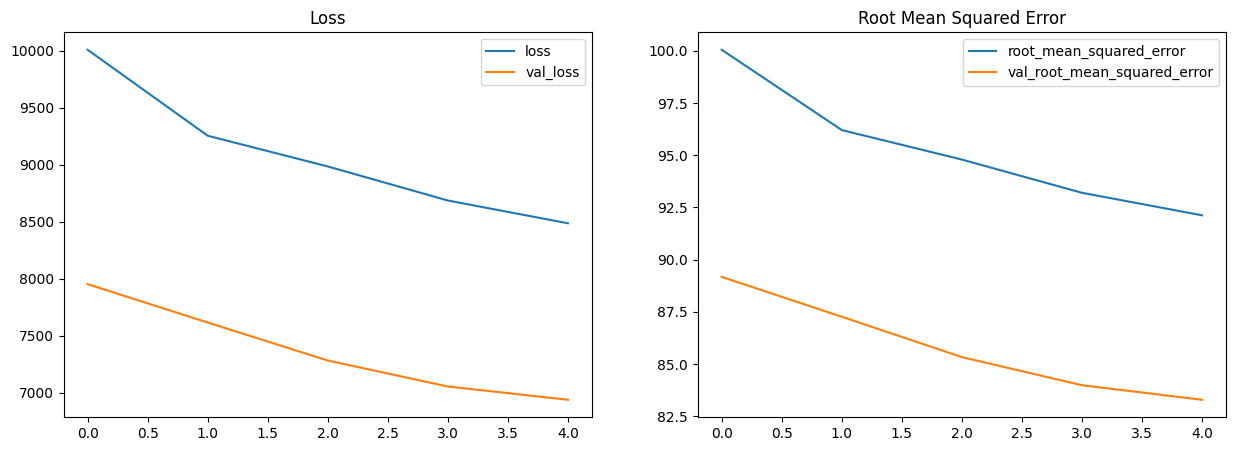

4/4 [==============================] - 1s 110ms/step - loss: 6937.9971 - root_mean_squared_error: 83.2946
{'loss': 6937.9970703125, 'root_mean_squared_error': 83.29463195800781}
Inference execution time (mins) 0.02156986395517985
Model before zip: 89.82 Kb
Model after zip: 66.19 Kb
      1/Unknown - 0s 126ms/step

<ipython-input-35-9ea667a9bd7d>:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, model_file, include_optimizer=False)


4/4 [==============================] - 0s 106ms/step
average calories off:  195.61940838491014
average mass off (grams):  151.74014451862112
average fat off (grams):  13.4299061677576
average carb off (grams):  14.99046499414678
average protein off (grams):  17.992725733699988


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[6937.9970703125, 83.29463195800781]

In [ ]:
# Get model training history
training_history = training_results.history

# Compile
after_prune.compile(optimizer=optimizer,
                      loss=loss,
                      metrics=[keras.metrics.RootMeanSquaredError()])

# Evaluate model
evaluate_model(after_prune, validation_data, training_history, execution_time,
               learning_rate, batch_size, epochs, optimizer,
               save=True,
               loss_metrics=["loss","val_loss"],
               acc_metrics=["root_mean_squared_error","val_root_mean_squared_error"])

#### **Model Size on Disk after Pruning**

Now if we `zip` our model after pruning we see a significant reduction in size.

In [ ]:
compare_model_sizes(after_prune)

Model before zip: 89.82 Kb
Model after zip: 66.19 Kb


<ipython-input-35-9ea667a9bd7d>:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, model_file, include_optimizer=False)


(89.816, 66.192)

In [ ]:
#Compare performance
models_folder = "models" # distil_models / models
models_metrics_list = glob(models_folder+"/*_metrics.json")

all_models_metrics = []
for mm_file in models_metrics_list:
  with open(mm_file) as json_file:
    model_metrics = json.load(json_file)
    model_metrics["name"] = mm_file.replace(models_folder+"/","").replace("_model_metrics.json","")
    all_models_metrics.append(model_metrics)

# Load metrics to dataframe
view_metrics = pd.DataFrame(data=all_models_metrics)

view_metrics.head()

,trainable_parameters,execution_time,loss,root_mean_squared_error,model_size,learning_rate,batch_size,epochs,optimizer,before_zip_size,...,min_mass_off,min_fat_off,min_carb_off,min_protein_off,max_calories_off,max_mass_off,max_fat_off,max_carb_off,max_protein_off,name
0,17077,0.140637,7241.944824,88.965431,95424,0.001,128,5,Adam,89.816,...,0.457260,0.011587,0.108448,0.107918,1129.653336,987.069290,73.574562,90.991766,126.017941,student_distill
1,17077,0.119842,8135.371094,90.196297,246216,0.001,128,5,Adam,89.816,...,0.434273,0.002576,0.027107,0.036485,1126.767166,980.701363,61.192446,85.023203,127.163572,student_scratch
2,82309,1.967088,30285.285156,174.026657,9948824,0.001,128,20,SGD,9613.728,...,0.637960,0.091132,0.008357,0.002551,1230.678345,1073.479574,64.138045,98.652769,141.119044,teacher_model
3,17077,0.089208,7974.030762,89.297424,246216,0.001,128,5,Adam,89.816,...,0.156631,0.036588,0.001383,0.037563,1170.783775,848.394669,64.818007,69.245327,133.587146,before_prune
4,17077,0.150682,6937.997070,83.294632,246216,0.001,128,5,Adam,89.816,...,0.217407,0.023050,0.045734,0.031796,1095.813965,966.308548,57.097648,80.769211,139.865185,after_prune


In [ ]:
get_model_size("after_prune")

246216

## **<font color="#324bd9">TFLite Quantization</font>**

https://www.tensorflow.org/lite/performance/post_training_quantization

Dynamic range quantization is a recommended starting point because it provides reduced memory usage and faster computation without you having to provide a representative dataset for calibration. This type of quantization, statically quantizes only the weights from floating point to integer at conversion time, which provides 8-bits of precision.

To further reduce latency during inference, "dynamic-range" operators dynamically quantize activations based on their range to 8-bits and perform computations with 8-bit weights and activations. This optimization provides latencies close to fully fixed-point inferences. However, the outputs are still stored using floating point so the increased speed of dynamic-range ops is less than a full fixed-point computation.

In [ ]:
#Without quantization

teacher_model.save("teacher_model")
saved_model_dir = "./teacher_model"
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()
#saving converted model in "converted_model.tflite" file
open("converted_model.tflite", "wb").write(tflite_model)

9213888

In [ ]:
teacher_model.save("teacher_model")
saved_model_dir = "./teacher_model"
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
open("converted_quant_model.tflite", "wb").write(tflite_quant_model)

2610184

Evaluate the reduction in size of the model. (Notice, it is approximately 3.5x)

In [ ]:
import os
print("Float model in Mb:", os.path.getsize('./converted_model.tflite') / float(2**20))
print("Quantized model in Mb:", os.path.getsize('./converted_quant_model.tflite') / float(2**20))
print("Compression ratio:", os.path.getsize('./converted_model.tflite')/os.path.getsize('converted_quant_model.tflite'))

Float model in Mb: 8.78704833984375
Quantized model in Mb: 2.4892654418945312
Compression ratio: 3.529976430780359


https://medium.com/@sonalimedani/post-training-quantization-with-tensorflow-lite-on-a-keras-model-f373068966c4


https://stackoverflow.com/questions/50764572/how-can-i-test-a-tflite-model-to-prove-that-it-behaves-as-the-original-model-us

In [ ]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="converted_quant_model.tflite")
interpreter.allocate_tensors()
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[33.430313  28.312765   1.6927513  2.2920249  2.6374521]]
